![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [6]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from math import log2
import matplotlib.pyplot as plt

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [58]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 40
max_features = None
min_gain=0.001

In [59]:
# Impresión variable a usar
j = 1
print(X.columns[j])

Mileage


In [60]:
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
print(splits)

[5.0000000e+00 6.4580500e+03 1.0470000e+04 1.3352350e+04 1.5764400e+04
 1.8086250e+04 2.0000300e+04 2.1561800e+04 2.3458600e+04 2.4955300e+04
 2.6461000e+04 2.8111850e+04 2.9937600e+04 3.1479600e+04 3.2926700e+04
 3.4304000e+04 3.5700800e+04 3.7083350e+04 3.8720800e+04 4.0265550e+04
 4.1680000e+04 4.3212750e+04 4.4793400e+04 4.6274150e+04 4.8247000e+04
 5.0563000e+04 5.3527100e+04 5.7630900e+04 6.1716000e+04 6.6410700e+04
 7.1355500e+04 7.6730300e+04 8.1534200e+04 8.7284150e+04 9.2865000e+04
 9.9207000e+04 1.0675780e+05 1.1619845e+05 1.2761000e+05 1.4629880e+05]


In [61]:
k=10
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [62]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [63]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
gini_l

-653088556.9195423

In [64]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
gini_r

-356990419.20446926

In [65]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [66]:
# Ganancia de la variable 'mileage' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

8320718.533031642

In [67]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las variables
    for j in features:
        
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


In [68]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 2014.0, 17349239.621991813)

In [69]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [70]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10495, 3356, 7139)

In [71]:
y.mean(), y_l.mean(), y_r.mean()

(14538.403716055265, 10242.713647199047, 16557.781201848997)

In [72]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [ ]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=40, num_pct=40)
tree

In [80]:
# Función para hacer predicciones usando el árbol de decisión
def predict_tree(tree, X):
    predictions = []
    for _, row in X.iterrows():
        predictions.append(predict_tree_recursive(tree, row))
    return predictions

# Función para predecir recursivamente el valor de la variable objetivo usando el árbol de decisión
def predict_tree_recursive(tree, row):
    if tree['split'] == -1:
        return tree['y_pred']
    else:
        if row[tree['split'][0]] < tree['split'][1]:
            return predict_tree_recursive(tree['sl'], row)
        else:
            return predict_tree_recursive(tree['sr'], row)

# Hacer predicciones en los datos de prueba
y_pred = predict_tree(tree, X_test)

# Calcular el RMSE y el MAE
rmse_arbol_manual = mean_squared_error(y_test, y_pred, squared=False)
mae_arbol_manual = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse_arbol_manual)
print("MAE:", mae_arbol_manual)


RMSE: 3751.0606693584486
MAE: 2105.8322748267897


El RMSE que obtuvimos de aproximadamente 3751.06 y el MAE de aproximadamente 2105.83 nos dan una medida del error promedio de nuestras predicciones del valor del precio de los automóviles, para este caso, el RMSE nos indica que en promedio, nuestras predicciones están desviadas en alrededor de 3751.06 del valor real, mientras que el MAE nos indica que en promedio estamos desviados en alrededor de 2105.83.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [75]:
# Paso 1: Crear las muestras de bootstrap
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_B)]

# Paso 2: Entrenar un árbol de decisión para cada muestra bootstrap y hacer predicciones
y_pred = np.zeros((len(X_test), n_B))  # Inicializar una matriz para guardar las predicciones

for i, sample in enumerate(samples):
    X_train_boot = X_train.iloc[sample]
    y_train_boot = y_train.iloc[sample]
    tree_reg = DecisionTreeRegressor(max_depth=None, random_state=123)
    tree_reg.fit(X_train_boot, y_train_boot)
    y_pred[:, i] = tree_reg.predict(X_test)

# Paso 3: Evaluar el desempeño de cada árbol
for i in range(n_B):
    print('Árbol', i, 'tiene un error:', np.sqrt(mean_squared_error(y_pred[:, i], y_test)))

# Paso 4: Calcular las predicciones promedio de todos los árboles
y_pred_avg = np.mean(y_pred, axis=1)

# Paso 5: Evaluar el error al promediar las predicciones de todos los árboles
rmse_avg = np.sqrt(mean_squared_error(y_pred_avg, y_test))
mae_avg = mean_absolute_error(y_pred_avg, y_test)

print('RMSE al promediar las predicciones de todos los árboles:', rmse_avg)
print('MAE al promediar las predicciones de todos los árboles:', mae_avg)

# Guardar el RMSE y el MAE en variables
rmse_bagging_manual = rmse_avg
mae_bagging_manual = mae_avg


Árbol 0 tiene un error: 2141.613353645869
Árbol 1 tiene un error: 2136.3519863123465
Árbol 2 tiene un error: 2122.718759132052
Árbol 3 tiene un error: 2087.278992468617
Árbol 4 tiene un error: 2168.518742842026
Árbol 5 tiene un error: 2113.8811455834793
Árbol 6 tiene un error: 2127.933470769012
Árbol 7 tiene un error: 2184.414847251443
Árbol 8 tiene un error: 2138.1071697514985
Árbol 9 tiene un error: 2132.097520859104
RMSE al promediar las predicciones de todos los árboles: 1796.4355868399332
MAE al promediar las predicciones de todos los árboles: 1340.0160739030025


De acuerdo con los anteriores resultados del baggin manual, observamos que cada árbol individualmente tiene errores diferentes, lo que es esperado ya que cada uno se entrena en una muestra bootstrap diferente, pero al promediar las predicciones de todos los árboles, observamos una disminución significativa en el error RMSE y MAE, lo que indica que el modelo Bagging está reduciendo la varianza y mejorando la generalización en comparación con un solo árbol de decisión. Por lo tanto, esta técnica de ensamblado ha logrado mejorar la precisión del modelo y ha demostrado ser efectiva para este problema de regresión.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [76]:
# Crear el modelo DecisionTreeRegressor base
base_model = DecisionTreeRegressor()

# Calcular el número de características para max_features
n_features = X_train.shape[1]
max_features = int(log2(n_features))

# Crear el modelo BaggingRegressor personalizado
bagging_model = BaggingRegressor(base_model, 
                                 n_estimators=10,  # Número de árboles
                                 max_features=max_features,  # Máximo número de características
                                 random_state=1)  # Semilla aleatoria para reproducibilidad

# Entrenar el modelo con los datos de entrenamiento
bagging_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = bagging_model.predict(X_test)

# Calcular el RMSE
rmse_lib = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el MAE
mae_lib = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse_lib)
print("MAE:", mae_lib)

rmse_bagging_libreria = rmse_lib
mae_bagging_libreria = mae_lib


RMSE: 2013.353269091173
MAE: 1523.7936523039218


Al hacer uso de la librería, únicamente se le indican los parámetros a utilizar, para este caso sé específica el logaritmo en base dos para conocer el número máximo de características a utilizar y se indica que el número de estimadores es 10, siendo este la cantidad de modelos para el ensamblaje. 

Como medidas de desempeño se utiliza el RMSE, con un resultado de 2013.35 y un MAE de 1523.79. 

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [42]:
# Celda 4
rf_base = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_base.fit(X_train, y_train)
y_pred_rfb = rf_base.predict(X_test)

3116678.915374798

In [51]:
rmse_4_rf = np.sqrt(mean_squared_error(y_pred_rfb, y_test))
mae_4_rf = mean_absolute_error(y_pred_rfb, y_test)
rmse_4_rf,mae_4_rf

(1765.4118259983413, 1314.4207078056425)

Se creó un modelo de RandomForest para regresión con los siguientes parámetros: (n_estimators=100, max_depth=None, min_samples_split=2, random_state=42). 

Se entrenó el modelo con la muestra de entranamiento y se realizó la predicción con los datos de prueba, obteniendo un RMSE de 1765,41 y un MAE de 1314,4.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5
parametros = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['sqrt', 'log2', None]
}
rf_5 = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_5,
                               param_distributions=parametros,
                               n_iter=100,     
                               cv=10,          
                               verbose=2,      
                               random_state=42,
                               scoring='neg_mean_squared_error')

rf_random.fit(X_train, y_train)

params_rf_random = rf_random.best_params_
score_rf_random  = -rf_random.best_score_
(params_rf_random, score_rf_random)

In [52]:
y_pred_rf5 = rf_random.best_estimator_.predict(X_test)
rmse_5_rf = np.sqrt(mean_squared_error(y_pred_rf5, y_test))
mae_5_rf = mean_absolute_error(y_pred_rf5, y_test)
rmse_5_rf,mae_5_rf

(1564.0053686456856, 1146.3575827164323)

Se realizó una busqueda aleatoria con validación cruzada de los parámetros indicados obteniendo los siguientes valores:
* n_estimators: 500
* max_features: sqrt
* max_depth: 10

Un mayor número de árboles (500) generalmente mejora la precisión del modelo porque las predicciones son el resultado de un promedio más grande y más estable de los árboles individuales. La selección de la raíz cuadrada para max_features ayuda a asegurar que los árboles del bosque sean diversos y que el modelo sea robusto, reduciendo el riesgo de sobreajuste. Un valor de 10 para max_depth permite que los árboles crezcan lo suficientemente profundos para capturar suficientemente las complejidades de los datos, pero no tan profundos como para aprender el ruido presente en ellos. 

El resultado fue de un RMSE de 1564.00 y un MAE de 1146.35

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [47]:
# Celda 6
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

parametros = {
    'max_depth': 1,
    'learning_rate': 0.5
}
xgb_6 = xgb.train(parametros ,dtrain,100)

In [53]:
y_pred_xgb_6 = xgb_6.predict(dtest)
rmse_6_rf = np.sqrt(mean_squared_error(y_pred_xgb_6, y_test))
mae_6_rf = mean_absolute_error(y_pred_xgb_6, y_test)
rmse_6_rf,mae_6_rf

(1587.6367732476585, 1181.3621173532676)

Al entrenar el modelo de XGBoost con unos parámetros base de 'max_depth': 1 y 'learning_rate': 0.5 se obtuvo un RMSE de 1587.63 y un MAE de 1181.36

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
xgb_7 = xgb.XGBRegressor()
parametros = {
    'learning_rate': [0.065, 0.07, 0.075, 0.08, 0.085],
    'gamma': [0.75, 0.775, 0.8, 0.825, 0.85],
    'colsample_bytree': [0.55, 0.575, 0.6, 0.625, 0.65]
}
xgb_random = RandomizedSearchCV(
    estimator=xgb_7,
    param_distributions=parametros,
    n_iter=1000,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42
)
xgb_random.fit(X_train, y_train)
params_7_xgb = xgb_random.best_params_
score_7_xgb = -xgb_random.best_score_
(params_7_xgb, score_7_xgb)

In [54]:
y_pred_7_xgb = xgb_random.best_estimator_.predict(X_test)
rmse_7_rf = np.sqrt(mean_squared_error(y_pred_7_xgb, y_test))
mae_7_rf = mean_absolute_error(y_pred_7_xgb, y_test)
rmse_7_rf,mae_7_rf

(1542.415028914825, 1133.677544644468)

Se realizó una busqueda aleatoria con validación cruzada de los parámetros indicados obteniendo los siguientes valores:
* learning_rate: 0.07
* gamma: 0.75
* colsample_bytree: 0.575

Un learning_rate moderadamente bajo como 0.07 ayuda a encontrar un buen equilibrio entre la precisión y la generalización. Un gamma de 0.75 ayuda a controlar el sobreajuste al hacer que el algoritmo sea conservador en términos de crecimiento del árbol. Un valor de 0.575 indica que en cada iteración de construcción de árbol se selecciona el 57.5% de las características totales al azar, lo que ayuda a prevenir el sobreajuste ya que cada árbol en el ensamblaje se construye con una muestra diferente y posiblemente complementaria de características.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

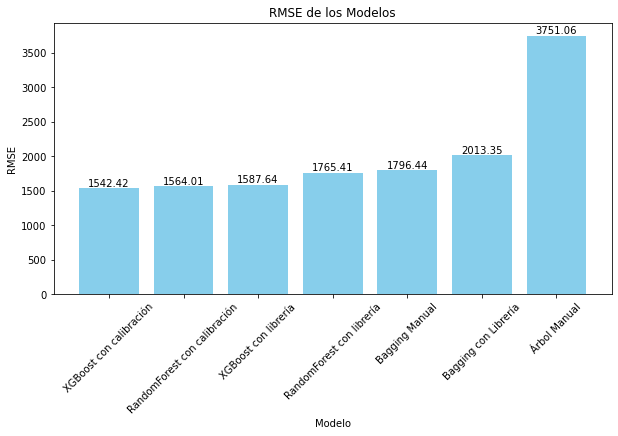

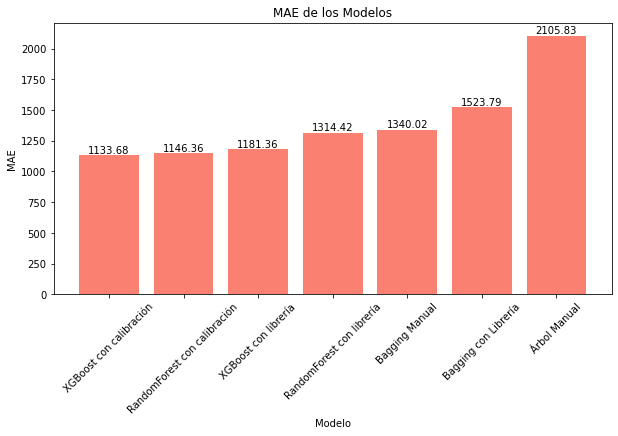

In [81]:
# Datos de RMSE y MAE
modelos = ['Árbol Manual', 'Bagging Manual', 'Bagging con Librería','RandomForest con librería','RandomForest con calibración'
           ,'XGBoost con librería','XGBoost con calibración']
rmse = [rmse_arbol_manual, rmse_bagging_manual, rmse_bagging_libreria,rmse_4_rf,rmse_5_rf,rmse_6_rf,rmse_7_rf]
mae = [mae_arbol_manual, mae_bagging_manual, mae_bagging_libreria,mae_4_rf,mae_5_rf,mae_6_rf,mae_7_rf]

sorted_indices_rmse = sorted(range(len(rmse)), key=lambda k: rmse[k])
sorted_indices_mae = sorted(range(len(mae)), key=lambda k: mae[k])

sorted_modelos_rmse = [modelos[i] for i in sorted_indices_rmse]
sorted_rmse = [rmse[i] for i in sorted_indices_rmse]

sorted_modelos_mae = [modelos[i] for i in sorted_indices_mae]
sorted_mae = [mae[i] for i in sorted_indices_mae]

# Graficar RMSE 
plt.figure(figsize=(10, 5))
plt.bar(sorted_modelos_rmse, sorted_rmse, color='skyblue')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('RMSE de los Modelos')
plt.xticks(rotation=45) 
for i in range(len(sorted_modelos_rmse)):
    plt.text(i, sorted_rmse[i], str(round(sorted_rmse[i], 2)), ha='center', va='bottom')
plt.show()

# Graficar MAE 
plt.figure(figsize=(10, 5))
plt.bar(sorted_modelos_mae, sorted_mae, color='salmon')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.title('MAE de los Modelos')
plt.xticks(rotation=45) 
for i in range(len(sorted_modelos_mae)):
    plt.text(i, sorted_mae[i], str(round(sorted_mae[i], 2)), ha='center', va='bottom')
plt.show()



El modelo con mejor desempeño en terminos de RMSE fue el XGBoost con calibración de parámetros con un resultado de 1542.42, y el modelo con menor desempeño en terminos de RMSE fue el Árbol con implementación manual con un resultado de 3751.06. Las ventajas del modelo de XGBoost son la capacidad de ensamblar múltiples árboles aplicando validación cruzada y técnicas de prevención del sobreajuste, además de representar un algoritmo más eficiente en términos de tiempo de entrenamiento y manejo de valores nulos. Las desventajas del modelo del árbol de decisión manual son que no representa ensamblaje de múltiples modelos y al ser una única configuración tienden a ser demasiado simples y pueden tener un sesgo considerable, lo que significa que pueden subestimar o sobreestimar la relación entre las características y la variable objetivo, lo que conlleva a predicciones inexactas, además que suelen tener una profundidad limitada debido a la complejidad de su construcción y la necesidad de interpretación humana.